# [**Comparaison des algorithmes de détection d'atypique pour la détection d'atypique sur des ensembles de données factices**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/misc/plot_anomaly_comparison.ipynb)<br/>([_Comparing anomaly detection algorithms for outlier detection on toy datasets_](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html))

Cet exemple montre les caractéristiques de différents algorithmes de détection d'atypique sur des ensembles de données 2D. Les ensembles de données contiennent un ou deux modes (régions de haute densité) pour illustrer la capacité des algorithmes à gérer des données multimodales.

Pour chaque ensemble de données, 15% des échantillons sont générés comme bruit aléatoire uniforme. Cette proportion est la valeur donnée au paramètre `nu` de l'objet [**`svm.OneClassSVM`**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html) et au paramètre `contamination` des autres algorithmes de détection d'atypique. Les frontières de décision entre les _inliers_ et les _outliers_ sont affichées en noir, sauf pour le Local Outlier Factor (LOF) car il n'a pas de méthode `predict` à appliquer sur de nouvelles données lorsqu'il est utilisé pour la détection d'atypique.

[**`svm.OneClassSVM`**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html) est connu pour être sensible aux valeurs atypiques et ne donne donc pas de très bons résultats pour la détection d'atypique. Cet estimateur convient mieux à la détection de nouveauté lorsque l'ensemble d'entraînement n'est pas contaminé par des valeurs atypiques. Cela dit, la détection d'atypique en haute dimension ou sans aucune hypothèse sur la distribution des données internes est très difficile, et un SVM en une seule classe peut donner des résultats utiles dans ces situations en fonction de la valeur de ses hyperparamètres.

[**`linear_model.SGDOneClassSVM`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDOneClassSVM.html) est une implémentation du SVM en une seule classe basée sur la descente de gradient stochastique (SGD). Combiné avec une approximation de noyau, cet estimateur peut être utilisé pour approximer la solution d'un SVM en une seule classe avec un noyau. Nous notons que, bien qu'ils ne soient pas identiques, les frontières de décision du [**`linear_model.SGDOneClassSVM`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDOneClassSVM.html) et celles de [**`svm.OneClassSVM`**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html) sont très similaires. Le principal avantage d'utiliser [**`linear_model.SGDOneClassSVM`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDOneClassSVM.html) est qu'il évolue linéairement avec le nombre d'échantillons.

[**`covariance.EllipticEnvelope`**](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html) suppose que les données sont gaussiennes et apprend une ellipse. Il perd en performance lorsque les données ne sont pas unimodales. Cependant, cet estimateur est robuste aux valeurs atypiques.

[**`ensemble.IsolationForest`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) et [**`neighbors.LocalOutlierFactor`**](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html) semblent bien performer pour les ensembles de données multimodaux. L'avantage de [**`neighbors.LocalOutlierFactor`**](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html) par rapport aux autres estimateurs est démontré pour le troisième ensemble de données, où les deux modes ont des densités différentes. Cet avantage est expliqué par l'aspect local de LOF, ce qui signifie qu'il ne compare que le score d'atypique d'un échantillon avec les scores de ses voisins.

Enfin, pour le dernier ensemble de données, il est difficile de dire qu'un échantillon est plus atypique qu'un autre échantillon car ils sont uniformément répartis dans un hypercube. Sauf pour le SVM à une seule classe ([**`svm.OneClassSVM`**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html)) qui surajuste un peu, tous les estimateurs qui présentent des solutions décentes pour cette situation. Dans un tel cas, il serait judicieux d'examiner de plus près les scores d'atypisme des échantillons car un bon estimateur devrait attribuer des scores similaires à tous les échantillons.

Bien que ces exemples donnent une certaine intuition sur les algorithmes, cette intuition peut ne pas s'appliquer aux données de très haute dimension.

Enfin, notez que les paramètres des modèles ont été ici choisis à la main, mais que dans la pratique, ils doivent être ajustés. En l'absence de données étiquetées, le problème est complètement non supervisé, donc la sélection du modèle peut être un défi.

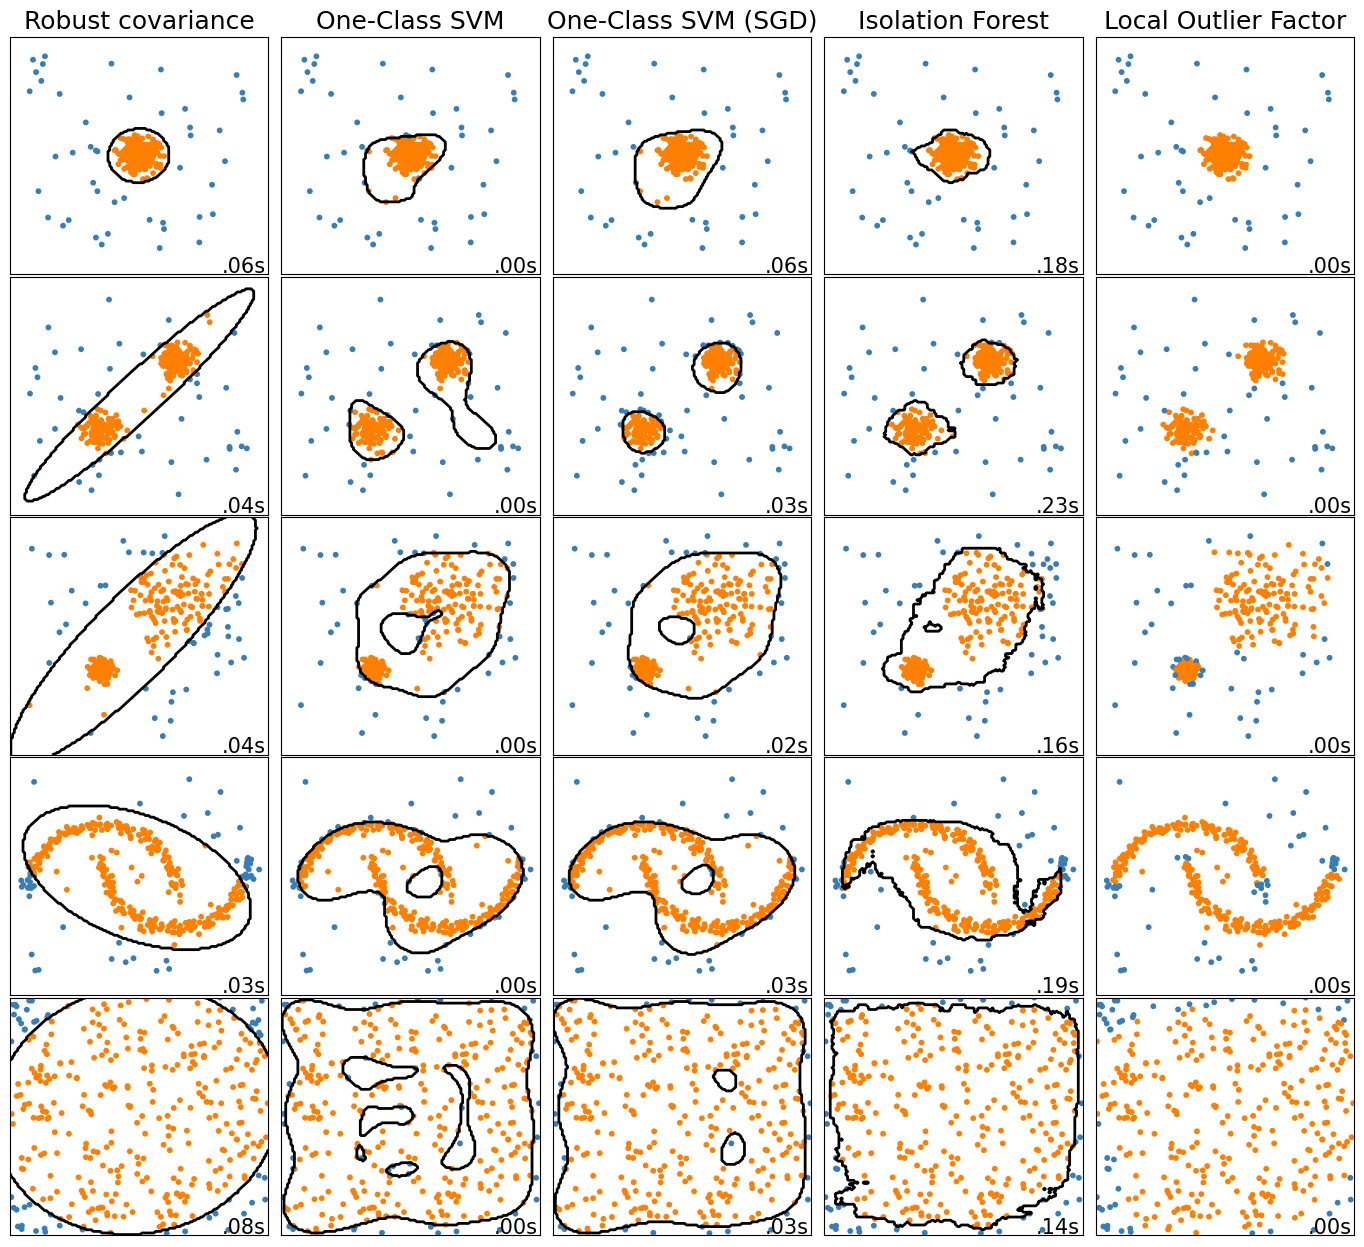

In [1]:
# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#         Albert Thomas <albert.thomas@telecom-paristech.fr>
# License: BSD 3 clause

import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.datasets import make_blobs, make_moons
from sklearn.ensemble import IsolationForest
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline

matplotlib.rcParams["contour.negative_linestyle"] = "solid"

# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# define outlier/anomaly detection methods to be compared.
# the SGDOneClassSVM must be used in a pipeline with a kernel approximation
# to give similar results to the OneClassSVM
anomaly_algorithms = [
    (
        "Robust covariance",
        EllipticEnvelope(contamination=outliers_fraction, random_state=42),
    ),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
    (
        "One-Class SVM (SGD)",
        make_pipeline(
            Nystroem(gamma=0.1, random_state=42, n_components=150),
            SGDOneClassSVM(
                nu=outliers_fraction,
                shuffle=True,
                fit_intercept=True,
                random_state=42,
                tol=1e-6,
            ),
        ),
    ),
    (
        "Isolation Forest",
        IsolationForest(contamination=outliers_fraction, random_state=42),
    ),
    (
        "Local Outlier Factor",
        LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction),
    ),
]

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)[0],
    4.0
    * (
        make_moons(n_samples=n_samples, noise=0.05, random_state=0)[0]
        - np.array([0.5, 0.25])
    ),
    14.0 * (np.random.RandomState(42).rand(n_samples, 2) - 0.5),
]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 4, 12.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

        colors = np.array(["#377eb8", "#ff7f00"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()